In [1]:
import numpy as np
from numpy import zeros, eye, array, r_, diag, ones, log, zeros_like, pi, exp, log10, sort, quantile, linspace, vstack
from numpy import save, nanmean
from numpy.random import randn, rand, randint, default_rng
from numpy.random import normal
from numpy import isfinite
from numpy.linalg import solve, det, inv, norm
from numpy import logspace

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from collections import OrderedDict
import copy

from warnings import catch_warnings, filterwarnings

from autograd import jacobian, grad
import autograd.numpy as anp
from autograd.numpy import ones as aones
from autograd.numpy import zeros as azeros
from autograd.numpy import exp as aexp
from autograd.numpy.linalg import det as adet
from autograd.numpy import log as alog
from autograd.numpy import diag as adiag
from autograd.numpy.linalg import norm as anorm
import autograd.scipy as asp
from autograd.scipy.stats import norm as andist
import autograd as ag
from autograd.scipy.special import gamma as agamma

from scipy.stats import multivariate_normal as MVN
from scipy.optimize import fsolve, bisect
from scipy.stats import norm as ndist
from scipy.stats import uniform as udist
from scipy.stats import beta as abetadist
from scipy.linalg import qr
from scipy.special import gamma

from g_and_k_functions import GandK
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from HMC.static_hmc import HMC
from utils import ESS_univariate, ESS

from mici.samplers import ChainState
from mici.systems import DenseConstrainedEuclideanMetricSystem as DCEMS
from mici.systems import EuclideanMetricSystem as EMS
from mici.integrators import ConstrainedLeapfrogIntegrator as CLI
from mici.integrators import LeapfrogIntegrator as LI
from mici.samplers import DynamicMultinomialHMC as DMHMC
from mici.samplers import StaticMetropolisHMC as SMHMC

import time

In [2]:
prangle_mcmc_samples = np.loadtxt(
    'ManifoldSamplingR/gk_mcmc_samples2.txt', skiprows=1, usecols=range(1, 5)
)[1:, :]

# G and K Parameters

In [3]:
# Parameters
θ0        = array([3.0, 1.0, 2.0, 0.5]) # True parameter value
m         = 50                          # Number of latent variables
d         = 4 + m                       # Dimensionality of ξ=(θ, z)
seed=1234

# G and K Functions

In [172]:
def f(ξ):
    """Deterministic simulator f: ξ -> y."""
    return ξ[0] + ξ[1]*(1 + 0.8*(1 - aexp(-ξ[2]*ξ[4:]))/(1 + aexp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]

def data_generator(θ0, m, seed):
    """Stochastic Simulator. Generates y given θ."""
    rng = default_rng(seed)
    z = rng.normal(size=m)
    return f(r_[θ0, z])

def Jf_transpose(ξ):
    """Transpose of the Jacobian of f."""
    return vstack((
        aones(len(ξ[4:])),
        (1 + 0.8 * (1 - aexp(-ξ[2] * ξ[4:])) / (1 + aexp(-ξ[2] * ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3]) * ξ[4:],
        8 * ξ[1] * (ξ[4:]**2) * ((1 + ξ[4:]**2)**ξ[3]) * aexp(ξ[2]*ξ[4:]) / (5 * (1 + aexp(ξ[2]*ξ[4:]))**2),
        ξ[1]*ξ[4:]*((1+ξ[4:]**2)**ξ[3])*(1 + 9*aexp(ξ[2]*ξ[4:]))*alog(1 + ξ[4:]**2) / (5*(1 + aexp(ξ[2]*ξ[4:]))),
        adiag(ξ[1]*((1+ξ[4:]**2)**(ξ[3]-1))*(((18*ξ[3] + 9)*(ξ[4:]**2) + 9)*aexp(2*ξ[2]*ξ[4:]) + (8*ξ[2]*ξ[4:]**3 + (20*ξ[3] + 10)*ξ[4:]**2 + 8*ξ[2]*ξ[4:] + 10)*aexp(ξ[2]*ξ[4:]) + (2*ξ[3] + 1)*ξ[4:]**2 + 1) / (5*(1 + aexp(ξ[2]*ξ[4:]))**2))
    ))

def Jf(ξ):
    """Jacobian of f."""
    return Jf_transpose(ξ).T

def check_jacobian(tol=1e-12):
    """Checks if Jacobian function is correct."""
    ξ = r_[θ0, randn(m)]
    return np.max(abs(Jf(ξ) - jacobian(f)(ξ))) < tol

def log_pθ_beta(θ):
    """Beta logprior for θ."""
    assert len(θ) == 4, "θ must be 4-dimensional but has length {}".format(len(θ))
    #return abetadist.logpdf(θ, a=2, b=2, scale=10).sum()
    # α=2.0 and β=2.0
    return (alog(θ/10) + alog(1-θ/10) -alog(2) -alog(2) + alog(agamma(4))- alog(10)).sum()
    
    
def log_pz(z):
    """Normal logprior for z."""
    return andist.logpdf(z).sum()

def logprior_beta(ξ):
    """Log prior on ξ using Beta(2,2) for θ."""
    return log_pθ_beta(ξ[:4]) + log_pz(ξ[4:])

def neg_logprior_beta(ξ):
    return - logprior_beta(ξ)

def sample_θ_beta():
    """Samples θ from Beta prior. """
    return abetadist.rvs(a=2, b=2, scale=10, size=4) #10*abetadist.rvs(a=2, b=2, scale=1, size=4)

def sample_prior_beta():
    """Samples from prior for ξ where p(θ) is a Beta(2,2)."""
    return anp.r_[sample_θ_beta(), randn(m)]

def log_normal_kernel(ξ, ystar, ϵ):
    """Log normal kernel density."""
    u = anorm(f(ξ) - ystar)
    return -u**2/(2*(ϵ**2)) -0.5*alog(2*pi*(ϵ**2))

def log_abc_posterior_beta(ξ, ystar, ϵ):
    """Log posterior density. """
    return logprior_beta(ξ) + log_normal_kernel(ξ, ystar, ϵ)

# def find_point_on_manifold(ystar, ϵ, max_iter=1000):
#     """Find a point on the data manifold."""
#     i = 0
#     with catch_warnings():
#         filterwarnings('error')
#         while i <= max_iter:
#             i += 1
#             try: 
#                 ξ_guess = sample_prior_beta()
#                 ξ_found = fsolve(lambda ξ: r_[f(ξ) - ystar, azeros(4)], ξ_guess)
#                 if not isfinite([log_abc_posterior_beta(ξ_found, ystar, ϵ)]):
#                     pass
#                 else:
#                     return ξ_found

#             except RuntimeWarning:
#                 continue
#         raise ValueError("Couldn't find a point, try again.")

def find_point_on_manifold(ystar, ϵ, max_iter=1000, tol=1.49012e-08):
    """Find a point on the data manifold."""
    i = 0
    with catch_warnings():
        filterwarnings('error')
        while i <= max_iter:
            i += 1
            try: 
                # Sample θ from the prior
                θfixed = sample_θ_beta()
                function = lambda z: f(r_[θfixed, z]) - ystar
                z_guess  = randn(m)
                z_found  = fsolve(function, z_guess, xtol=tol)
                ξ_found  = r_[θfixed, z_found]
                if not isfinite([log_abc_posterior_beta(ξ_found, ystar, ϵ)]):
                    pass
                else:
                    return ξ_found

            except RuntimeWarning:
                continue
        raise ValueError("Couldn't find a point, try again.")    
        
def find_point_on_manifold_from_θ(ystar, θfixed, ϵ, max_iter=2000, tol=1.49012e-08):
    """Same as the above but we provide the θfixed. Can be used to find a point where
    the theta is already θ0."""
    function = lambda z: f(r_[θfixed, z]) - ystar
    z_guess  = randn(m)
    z_found  = fsolve(function, z_guess, xtol=tol)
    ξ_found  = r_[θfixed, z_found]
    if not isfinite([log_abc_posterior_beta(ξ_found, ystar, ϵ)]):
        raise ValueError("Couldn't find a point.")
    else:
        return ξ_found

# def beta_pdf(x, α, β, loc=0.0, scale=1.0):
#     y = (x - loc) / scale
#     return ((y**(α-1))*((1-y)**(β-1)) / (gamma(α)*gamma(β)*scale)) * gamma(α + β)
# def beta_logpdf(x, α, β, loc=0.0, scale=1.0):
#     y = (x - loc) / scale
#     return (α - 1)*log(y) + (β - 1)*log(1-y) - log(gamma(α)) - log(gamma(β)) + log(gamma(α + β)) - log(scale)

        
def is_on_manifold(ξ, ystar, tol=1e-8):
    """Checks if ξ is on the ystar manifold."""
    return np.max(abs(f(ξ) - ystar)) < tol
        
q = MVN(zeros(d), eye(d))

# Check that THUG, RWM and HMC work

In [5]:
ystar = data_generator(θ0, m, seed=seed)

In [6]:
# ξ0 = find_point_on_manifold2(ystar, ϵ=1.0, max_iter=2000)

In [7]:
T = 0.2
B = 5
# N = 1000
# α = 0.0
# ϵ = 1.0

In [8]:
# start_time = time.time()
# thug_samples, thug_acc = HugTangentialMultivariate(
#     x0=ξ0,
#     T=T,
#     B=B,
#     N=N,
#     α=α,
#     q=q,
#     logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵ),
#     jac=Jf
# )
# runtimeTHUG = time.time() - start_time

In [8]:
# start_time = time.time()
# rwm_samples, rwm_acc = RWM(x0=ξ0, s=(T/B), N=N, logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ))
# runtimeRWM = time.time() - start_time

In [9]:
# neg_log_abc_posterior_beta      = lambda ξ: - log_abc_posterior_beta(ξ, ystar, ϵ)
# grad_neg_log_abc_posterior_beta = grad(neg_log_abc_posterior_beta)
# trace_function                  = lambda state: {'θ{}'.format(i): state.pos[i] for i in range(len(ξ0))}
# system     = EMS(
#     neg_log_dens=neg_log_abc_posterior_beta, 
#     grad_neg_log_dens=grad_neg_log_abc_posterior_beta
# )
# integrator = LI(system, step_size=(T/B)/100)
# sampler    = SMHMC(system, integrator, default_rng(seed=seed), n_step=B)
# init_state = ChainState(pos=ξ0, mom=None, dir=1, _call_counts={})
# start_time = time.time()
# finalHMC, traceHMC, statHMC = sampler.sample_chain(n_iter=N, init_state=init_state, trace_funcs=[trace_function], display_progress=False)
# runtimeHMC = time.time() - start_time
# hmc_samples = np.vstack([traceHMC[key] for key in traceHMC.keys()]).T

# Check that C-HMC works

In [68]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

from symnum import matrix_hessian_product
from symnum import jacobian as jacobian_symnum
from symnum import grad as grad_symnum
from symnum import numpify
import symnum.numpy as snp

from math import e

In [86]:
def run_chmc(ystar, d, ξ0):
    # Define settings and variables
    theta0    = snp.array([3.0, 1.0, 2.0, 0.5])    # True parameter value
    n_latents = 50                                 # Number of latents = Dim of data
    n_params  = len(theta0)                        # Parameters are a, b, g, k
    d         = n_params + n_latents               # Dim of xi=(theta, z)
    # Define functions
    def deterministic_simulator(xi):
        """Deterministic simulator for G and K distribution. Maps (theta, z) -> y."""
        a, b, g, k, *z = xi
        z = np.array(z)
        return a + b*(1 + 0.8*np.tanh(g*z/2))*z*(1+z**2)**k

    @numpify(d)
    def neg_logprior(xi):
        """Log prior on the unconstrained space. For theta we use a Beta(2,2) rescaled
        over (0, 10) while for z we use a standard normal."""
        theta, z = xi[:4], xi[4:]
        return -(snp.log(theta/10) + snp.log(1-theta/10)).sum() + 0.5*z@z
    
    @numpify(d)
    def constr(xi):
        return (xi[0] + xi[1]*(1 + 0.8*(1 - e**(-xi[2]*xi[4:]))/(1 + e**(-xi[2]*xi[4:])))*xi[4:]*(1+xi[4:]**2)**xi[3]) - ystar
    
    jacob_constr = jacobian_symnum(constr, return_aux=True)
    trace_function = lambda state: {'xi{}'.format(i): state.pos[i] for i in range(len(ξ0))}

    grad_neg_log_prior = grad_symnum(neg_logprior)
    # Prep MICI
    system = DCEMS(
        neg_log_dens=neg_logprior, 
        constr=constr, 
        jacob_constr=jacob_constr, 
        grad_neg_log_dens=grad_neg_log_prior,
        dens_wrt_hausdorff=False
    )
    integrator  = CLI(system, step_size=T/B)
    sampler     = SMHMC(system, integrator, np.random.default_rng(1234), n_step=B)
    init_state  = ChainState(pos=ξ0, mom=None, dir=1, _call_counts={})
    # Run MICI
    return sampler.sample_chain(
        n_iter=N, 
        init_state=init_state, 
        trace_funcs=[trace_function], 
        display_progress=True
    )

In [87]:
run_chmc(ystar, d, ξ0)

Chain 1/1:   0%|          |0/1000 [00:00<?, ?]

IndexError: index 50 is out of bounds for axis 0 with size 50

# Run Experiments

In [9]:
ystar = data_generator(θ0, m, seed=seed)

In [11]:
ϵs = logspace(start=1, stop=-5, num=6, endpoint=True)
seeds  = array([1111, 2222, 3333, 4444, 5555, 6666])
assert len(ϵs) == len(seeds)
ystars = [ystar for ϵ in ϵs] #[data_generator(θ0, m, seed=seed) for seed in seeds]
n_repeats = 4
N_samples = 10000

In [12]:
ξ0s = []
# find point that works for smallest ϵ
ξ0_found = find_point_on_manifold(ystars[0], ϵ=ϵs[-1], max_iter=2000)
ξ0s = [ξ0_found for ϵ in ϵs]
# for (ystar, ϵ) in zip(ystars, ϵs):
#     #ξ0s.append(find_point_on_manifold2(ystar, ϵ=ϵ, max_iter=2000))
    

### Run THUG ($\alpha=0.0$) for all epsilons

In [13]:
thug_cc = zeros((n_repeats, len(ϵs)))
thug_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        start_time = time.time()
        thug_samples, thug_acc = HugTangentialMultivariate(
            x0=ξ0,
            T=T,
            B=B,
            N=N_samples,
            α=0.0,
            q=q,
            logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵ),
            jac=Jf
        )
        runtimeTHUG = time.time() - start_time
        thug_cc[i, ix] = min(ESS_univariate(thug_samples)) / runtimeTHUG
        thug_ap[i, ix] = thug_acc.mean()

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


# Run THUG ($\alpha=0.99$) for all epsilons

In [14]:
thug99_cc = zeros((n_repeats, len(ϵs)))
thug99_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        start_time = time.time()
        thug_samples, thug_acc = HugTangentialMultivariate(
            x0=ξ0,
            T=T,
            B=B,
            N=N_samples,
            α=0.99,
            q=q,
            logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵ),
            jac=Jf
        )
        runtimeTHUG = time.time() - start_time
        thug99_cc[i, ix] = min(ESS_univariate(thug_samples)) / runtimeTHUG
        thug99_ap[i, ix] = thug_acc.mean()

# Run RWM for all $\epsilon$s

In [15]:
rwm_cc = zeros((n_repeats, len(ϵs)))
rwm_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        start_time = time.time()
        rwm_samples, rwm_acc = RWM(x0=ξ0, s=(T/B), N=N_samples, logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ))
        runtimeRWM = time.time() - start_time
        rwm_cc[i, ix] = min(ESS_univariate(rwm_samples)) / runtimeRWM
        rwm_ap[i, ix] = rwm_acc.mean()

# Run HMC for all $\epsilon$s

In [16]:
hmc_cc = zeros((n_repeats, len(ϵs)))
hmc_ap = zeros((n_repeats, len(ϵs)))
hmc_unique = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        neg_log_abc_posterior_beta      = lambda ξ: - log_abc_posterior_beta(ξ, ystar, ϵ)
        grad_neg_log_abc_posterior_beta = grad(neg_log_abc_posterior_beta)
        trace_function                  = lambda state: {'θ{}'.format(i): state.pos[i] for i in range(len(ξ0))}
        system     = EMS(
            neg_log_dens=neg_log_abc_posterior_beta, 
            grad_neg_log_dens=grad_neg_log_abc_posterior_beta
        )
        integrator = LI(system, step_size=(T/B))
        sampler    = SMHMC(system, integrator, default_rng(seed=seeds[ix]), n_step=B)
        init_state = ChainState(pos=ξ0, mom=None, dir=1, _call_counts={})
        start_time = time.time()
        finalHMC, traceHMC, statHMC = sampler.sample_chain(n_iter=N_samples, init_state=init_state, trace_funcs=[trace_function], display_progress=False)
        runtimeHMC = time.time() - start_time
        hmc_samples = np.vstack([traceHMC[key] for key in traceHMC.keys()]).T
        hmc_cc[i, ix] = min(ESS_univariate(hmc_samples)) / runtimeHMC
        hmc_ap[i, ix] = statHMC['accept_stat'].mean()
        hmc_unique[i, ix] = np.unique(hmc_samples, axis=0).shape[0]

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in true_divide
  return f_raw(*args, **kwargs)
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/555238152.py:3: RuntimeWarning: invalid value encountered in true_divide
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - aexp(-ξ[2]*ξ[4:]))/(1 + aexp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g:

# Run C-RWM for all epsilons

In [271]:
crwm_cc = zeros((n_repeats, len(ϵs)))
crwm_ap = zeros((n_repeats, len(ϵs)))
for (ix, ϵ), ystar, ξ0 in zip(enumerate(ϵs), ystars, ξ0s):
    for i in range(n_repeats):
        # Prep manifold
        manifold = GKManifold(ystar=ystar)
        # Run
        start_time = time.time()
        crwm_samples, crwm_evals, crwm_acc  = zappa_sampling_storecomps(ξ0, manifold, manifold.logpost, manifold.logp, N_samples, T, tol=1e-8)
        runtimeCRWM = time.time() - start_time
        crwm_cc[i, ix] = min(ESS_univariate(crwm_samples)) / runtimeCRWM
        crwm_ap[i, ix] = crwm_acc.mean()

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/712030013.py:20: RuntimeWarning: invalid value encountered in log
  return (np.log(θ/10) + np.log(1-θ/10)).sum() - np.log(det(J@J.T))/2 -z@z/2
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=8.48149e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=9.78772e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=9.70599e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=9.97386e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.00977e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.00981e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.00674e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.27792e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.27779e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.39848e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.40291e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.41933e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.41941e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.06273e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.41852e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.07364e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.29992e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.30017e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.30018e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.54737e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.16832e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.17688e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.17687e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.61996e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.94759e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.97177e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.9718e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=8.15878e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=8.16961e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=8.16962e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.63341e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.81047e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.94514e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.91992e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.91777e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.0473e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.04736e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=9.69678e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.8813e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.17649e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.17578e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.17672e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.1761e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.61267e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.61279e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.20784e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.42048e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.73249e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.02632e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.08581e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.15518e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.2154e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.21538e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.21537e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.21542e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.93105e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.113e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.20118e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.20469e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.23964e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.24024e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.23953e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.23944e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.31753e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.31776e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.31744e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.31784e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.04568e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.52052e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.5248e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.52479e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.6932e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.69323e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.69322e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.69321e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.37105e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.37106e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.37109e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.3711e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.05541e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.05535e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.05543e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.05537e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.80313e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.80322e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.3788e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.49102e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.45818e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.4582e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.45821e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.45822e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.88827e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.07539e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.0754e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.07544e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.33616e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.29329e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.74269e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.7172e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.27132e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.28615e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.28601e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.27604e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.61307e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.34553e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.12036e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.11141e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.54828e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.33003e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.54752e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=4.54829e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.98936e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.02388e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.89374e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.98249e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.27741e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.34719e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.45399e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.63938e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.60479e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.15702e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.0844e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.08207e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.05824e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.0229e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.05767e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.0581e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.75736e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.15946e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.17664e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.17662e-18): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.29441e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.5013e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.50424e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.61669e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000g

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.42537e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.44272e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.42215e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=2.44273e-19): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.65041e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.23376e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.22554e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=7.89559e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=3.97273e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.49453e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=8.11002e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.23544e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=5.37049e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.89885e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.94662e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=6.94632e-17): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.07395e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.07393e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.07401e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/184270580.py:10: LinAlgWarning: Ill-conditioned matrix (rcond=1.07403e-16): result may not be accurate.
  delta_a = la.solve(grad_q(z + Q @ a).transpose() @ Q, -q(z + Q @ a))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000

ValueError: array must not contain infs or NaNs

In [17]:
# # Plot minESS/time as \sigma varies, in log-log scale
# max_index = len(ϵs)
# rc('font',**{'family':'STIXGeneral'})
# fig, ax = plt.subplots()
# ax.plot(ϵs[:max_index], (nanmean(thug_cc, axis=0)*(thug_ap.mean(axis=0) > 0).astype('float'))[:max_index], label='THUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='navy', color='dodgerblue', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], (nanmean(thug99_cc, axis=0)*(thug99_ap.mean(axis=0) > 0).astype('float'))[:max_index], label='αTHUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='purple', color='thistle', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], (nanmean(hmc_cc, axis=0)*(hmc_ap.mean(axis=0) > 0).astype('float'))[:max_index], label='HMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='brown', color='lightcoral', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], (nanmean(rwm_cc, axis=0)*(rwm_ap.mean(axis=0) > 0).astype('float'))[:max_index], label='RWM', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='darkgreen', color='yellowgreen', markeredgewidth=2.0)
# # ax.plot(ϵs[:max_index], nanmean(chmc_cc, axis=0)[:max_index], label='CHMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='black', color='darkgrey', markeredgewidth=2.0)
# # ax.plot(σlist, nanmean(THUG_CC99, axis=1), label='THUG99', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC90, axis=1), label='THUG90', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC95, axis=1), label='THUG95', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC995, axis=1), label='THUG995', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC80, axis=1), label='THUG80', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC50, axis=1), label='THUG50', marker='o')
# ax.set_xlabel(r'Noise Scale ' + r'$\mathregular{\sigma}$', fontsize=16)
# ax.set_ylabel(r'MinESS / runtime', fontsize=16)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)
# ax.loglog()
# # ax.set_ylim([-1, 5])
# # ax.set_xscale('log')
# ax.set_xticks(ticks=ϵs[:max_index])
# #plt.savefig('figures/computational_cost_bip_as_sigma_decreases.png', dpi=300)
# plt.show()

In [18]:
# # Plot minESS/time as \sigma varies, in log-log scale
# max_index = len(ϵs)
# rc('font',**{'family':'STIXGeneral'})
# fig, ax = plt.subplots()
# ax.plot(ϵs[:max_index], nanmean(thug_cc, axis=0)[:max_index], label='THUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='navy', color='dodgerblue', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], nanmean(thug99_cc, axis=0)[:max_index], label='αTHUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='purple', color='thistle', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], nanmean(hmc_cc, axis=0)[:max_index], label='HMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='brown', color='lightcoral', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], nanmean(rwm_cc, axis=0)[:max_index], label='RWM', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='darkgreen', color='yellowgreen', markeredgewidth=2.0)
# # ax.plot(ϵs[:max_index], nanmean(chmc_cc, axis=0)[:max_index], label='CHMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='black', color='darkgrey', markeredgewidth=2.0)
# # ax.plot(σlist, nanmean(THUG_CC99, axis=1), label='THUG99', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC90, axis=1), label='THUG90', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC95, axis=1), label='THUG95', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC995, axis=1), label='THUG995', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC80, axis=1), label='THUG80', marker='o')
# # ax.plot(σlist, nanmean(THUG_CC50, axis=1), label='THUG50', marker='o')
# ax.set_xlabel(r'Noise Scale ' + r'$\mathregular{\sigma}$', fontsize=16)
# ax.set_ylabel(r'MinESS / runtime', fontsize=16)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)
# ax.loglog()
# # ax.set_ylim([-1, 5])
# # ax.set_xscale('log')
# ax.set_xticks(ticks=ϵs[:max_index])
# #plt.savefig('figures/computational_cost_bip_as_sigma_decreases.png', dpi=300)
# plt.show()

array([0.50859873, 0.50859873, 0.50859873, 0.50859873, 0.50859873,
       0.50859873])

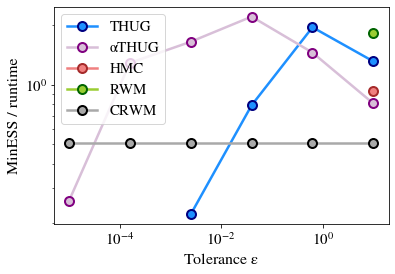

In [275]:
# process data so that when there is a zero acceptance probability, we put NaN
def process(cc, ap):
    cc_mean = nanmean(cc, axis=0)
    cc_mean[ap.mean(axis=0) <= 1e-16] = np.nan
    return cc_mean


    

# Plot minESS/time as \sigma varies, in log-log scale
max_index = len(ϵs)
rc('font',**{'family':'STIXGeneral'})
fig, ax = plt.subplots()
ax.plot(ϵs[:max_index], process(thug_cc, thug_ap)[:max_index], label='THUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='navy', color='dodgerblue', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], process(thug99_cc, thug99_ap)[:max_index], label='αTHUG', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='purple', color='thistle', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], process(hmc_cc, hmc_ap)[:max_index], label='HMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='brown', color='lightcoral', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], process(rwm_cc, rwm_ap)[:max_index], label='RWM', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='darkgreen', color='yellowgreen', markeredgewidth=2.0)
ax.plot(ϵs[:max_index], np.repeat(crwm_cc.mean(), max_index), label='CRWM', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='black', color='darkgrey', markeredgewidth=2.0)
# ax.plot(ϵs[:max_index], nanmean(chmc_cc, axis=0)[:max_index], label='CHMC', marker='o', linewidth=2.5, markersize=9.0, markeredgecolor='black', color='darkgrey', markeredgewidth=2.0)
# ax.plot(σlist, nanmean(THUG_CC99, axis=1), label='THUG99', marker='o')
# ax.plot(σlist, nanmean(THUG_CC90, axis=1), label='THUG90', marker='o')
# ax.plot(σlist, nanmean(THUG_CC95, axis=1), label='THUG95', marker='o')
# ax.plot(σlist, nanmean(THUG_CC995, axis=1), label='THUG995', marker='o')
# ax.plot(σlist, nanmean(THUG_CC80, axis=1), label='THUG80', marker='o')
# ax.plot(σlist, nanmean(THUG_CC50, axis=1), label='THUG50', marker='o')
ax.set_xlabel(r'Tolerance ' + r'$\mathregular{\epsilon}$', fontsize=16)
ax.set_ylabel(r'MinESS / runtime', fontsize=16)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)
ax.loglog()
# ax.set_xticks(ticks=ϵs[:max_index], labels=['$\mathregular{{10^{{}}}}$'.format(-i) for i in range(len(ϵs))])
# ax.set_ylim([-1, 5])
# ax.set_xscale('log')
plt.savefig('figures/computational_cost_gk_as_sigma_decreases.png', dpi=300)
plt.show()

# Display Densities at their best

In [51]:
THUG_SAMPLES_BEST, THUG_ACC_BEST = HugTangentialMultivariate(
    x0=ξ0,
    T=T,
    B=B,
    N=50000,
    α=0.0,
    q=q,
    logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵs[-3]),
    jac=Jf
)

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [56]:
THUG99_SAMPLES_BEST, THUG99_ACC_BEST = HugTangentialMultivariate(
    x0=ξ0,
    T=T,
    B=B,
    N=50000,
    α=0.99,
    q=q,
    logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵs[-2]),
    jac=Jf
)

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [54]:
RWM_SAMPLES_BEST, RWM_ACC_BEST = RWM(x0=ξ0, s=(T/B), N=50000, logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵs[0]))

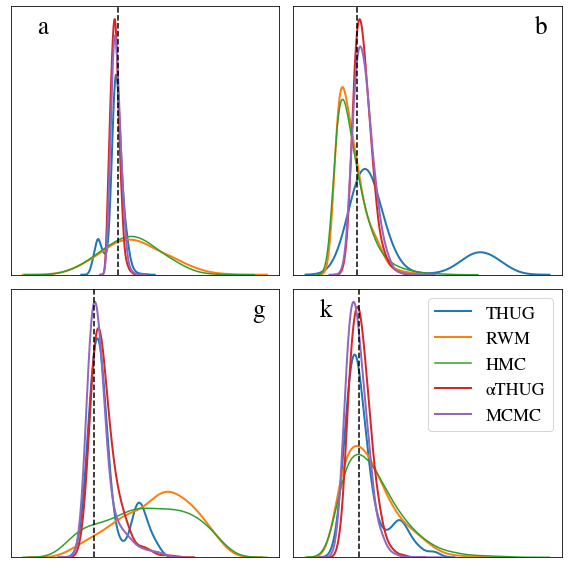

In [147]:
SMOOTH = 0.3
LABELS = ['a', 'b', 'g', 'k']
LW = 2
FROM = 10000
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(4):
    # THUG α=0.0
    _ = sns.kdeplot(THUG_SAMPLES_BEST[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='THUG'.format(THUG_ACC_BEST.mean()), lw=LW)
    # RWM
    _ = sns.kdeplot(RWM_SAMPLES_BEST[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='RWM'.format(RWM_ACC_BEST.mean()), lw=LW)
    # HMC 
    _ = sns.kdeplot(HMC_SAMPLES_BEST[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HMC'.format(HMC_ACC_BEST.mean()))
#     _ = sns.kdeplot(sHMC[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HMC'.format(acceptances4_2.mean()), lw=LW)
    # THUG 0.99
    _ = sns.kdeplot(THUG99_SAMPLES_BEST[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='αTHUG'.format(THUG99_ACC_BEST.mean()), lw=LW)
    # Prangle samples
    _ = sns.kdeplot(prangle_mcmc_samples[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='MCMC', lw=LW)
    
    # Prettify
    ax[i // 2, i % 2].axvline(θ0[i], c='k', ls='--')
#     ax[i // 2, i % 2].set_xlabel(r'${}$'.format(LABELS[i]), fontsize=20)
    # Remove the xlabel if (0, 1) or (1, 1)
    if i % 2 == 1:
        ax[i // 2, i % 2].set_ylabel("")
    
    # Set axes limits to the min, max of HUG/THUG
    #ax[i // 2, i % 2].set_xlim([min(THUG_SAMPLES_BEST[:, i].min(), THUG99_SAMPLES_BEST[:, i].min())-0.1, max(THUG_SAMPLES_BEST[:, i].max(), THUG99_SAMPLES_BEST[:, i].max()) + 0.1])
    ax[i // 2, i % 2].set_ylabel("")
    ax[i // 2, i % 2].set_yticks([])
    ax[i // 2, i % 2].set_xticks([])
    x_pos = 0.1 if (i // 2 == i % 2) else 0.9
    ax[i // 2, i % 2].text(x_pos, 0.9, "{}".format(LABELS[i]), transform=ax[i //2, i % 2].transAxes, fontsize=25, fontfamily='STIXGeneral')
#fig.suptitle(r'$\epsilon$ = {}'.format(ϵ), fontsize=20)
plt.tight_layout()
plt.legend(prop={'family':'STIXGeneral', 'size':18})
###################plt.savefig("figures/gk_eps10m3.png", dpi=300)
#plt.savefig("figures/gk_best_epsilon_new.png", dpi=300)
plt.show()

In [183]:
def run_hmc(ξ0, N, ϵ):
    neg_log_abc_posterior_beta      = lambda ξ: - log_abc_posterior_beta(ξ, ystar, ϵ)
    grad_neg_log_abc_posterior_beta = grad(neg_log_abc_posterior_beta)
    trace_function                  = lambda state: {'ξ{}'.format(i): state.pos[i] for i in range(len(ξ0))}
    system     = EMS(
        neg_log_dens=neg_log_abc_posterior_beta, 
        grad_neg_log_dens=grad_neg_log_abc_posterior_beta
    )
    integrator = LI(system, step_size=(T/B))
    sampler    = SMHMC(system, integrator, default_rng(seed=seed), n_step=B)
    init_state = ChainState(pos=ξ0, mom=None, dir=1, _call_counts={})
    start_time = time.time()
    finalHMC, traceHMC, statHMC = sampler.sample_chain(n_iter=N, init_state=init_state, trace_funcs=[trace_function], display_progress=False)
    runtimeHMC = time.time() - start_time
    hmc_acc = statHMC['accept_stat']
    hmc_samples = np.vstack([traceHMC[key] for key in traceHMC.keys()]).T
    return hmc_samples, hmc_acc

In [129]:
HMC_SAMPLES_BEST, HMC_ACC_BEST = run_hmc(ξ0, 50000, ϵs[-6])

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/555238152.py:3: RuntimeWarning: invalid value encountered in true_divide
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - aexp(-ξ[2]*ξ[4:]))/(1 + aexp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/555238152.py:3: RuntimeWarning: overflow encountered in power
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - aexp(-ξ[2]*ξ[4:]))/(1 + aexp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]


In [130]:
HMC_ACC_BEST.mean()

0.9736922683277338

# Plot densities at their best but starting from $\theta0$

In [175]:
ξ0_with_θ0 = find_point_on_manifold_from_θ(ystar, θ0, ϵs[-1])

In [176]:
THUG_SAMPLES_BESTθ0, THUG_ACC_BESTθ0 = HugTangentialMultivariate(
    x0=ξ0_with_θ0,
    T=T,
    B=B,
    N=50000,
    α=0.0,
    q=q,
    logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵs[-3]),
    jac=Jf
)

In [179]:
THUG99_SAMPLES_BESTθ0, THUG99_ACC_BESTθ0 = HugTangentialMultivariate(
    x0=ξ0_with_θ0,
    T=T,
    B=B,
    N=50000,
    α=0.99,
    q=q,
    logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵs[-2]),
    jac=Jf
)

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [180]:
RWM_SAMPLES_BESTθ0, RWM_ACC_BESTθ0 = RWM(x0=ξ0_with_θ0, s=(T/B), N=50000, logpi=lambda ξ: log_abc_posterior_beta(ξ, ystar, ϵ=ϵs[0]))

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [184]:
HMC_SAMPLES_BESTθ0, HMC_ACC_BESTθ0 = run_hmc(ξ0_with_θ0, 50000, ϵs[-6])

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in true_divide
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/3049499054.py:3: RuntimeWarning: invalid value encountered in true_divide
  return ξ[0] + ξ[1]*(1 + 0.8*(1 - aexp(-ξ[2]*ξ[4:]))/(1 + aexp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:]
/opt/anaconda3/envs/mani

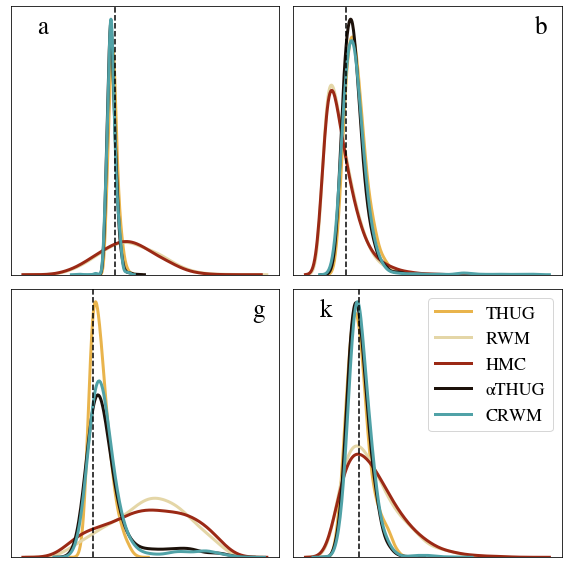

In [292]:
SMOOTH = 0.3
LABELS = ['a', 'b', 'g', 'k']
LW = 3
FROM = 0
COLOR_THUG = "#1C110A"  # Dark Grey
COLOR_HUG  = "#E9B44C"  # Dark Yellow
COLOR_CRWM = "#50A2A7"  # Light Blue
COLOR_RWM  = "#E4D6A7"  # Light Yellow
COLOR_HMC  = "#9B2915"  # Dark Red
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(4):
    # THUG α=0.0
    _ = sns.kdeplot(THUG_SAMPLES_BESTθ0[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='THUG'.format(THUG_ACC_BESTθ0.mean()), lw=LW, color=COLOR_HUG)
    # RWM
    _ = sns.kdeplot(RWM_SAMPLES_BESTθ0[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='RWM'.format(RWM_ACC_BESTθ0.mean()), lw=LW, color=COLOR_RWM)
    # HMC 
    _ = sns.kdeplot(HMC_SAMPLES_BESTθ0[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HMC'.format(HMC_ACC_BESTθ0.mean()), color=COLOR_HMC, lw=LW)
#     _ = sns.kdeplot(sHMC[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='HMC'.format(acceptances4_2.mean()), lw=LW)
    # THUG 0.99
    _ = sns.kdeplot(THUG99_SAMPLES_BESTθ0[FROM:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='αTHUG'.format(THUG99_ACC_BESTθ0.mean()), lw=LW, color=COLOR_THUG)
    # Prangle samples
#     _ = sns.kdeplot(prangle_mcmc_samples[:, i], ax=ax[i // 2, i % 2], bw_method=SMOOTH, label='MCMC', lw=LW)
    # zappa samples
    _ = sns.kdeplot(crwm_samples[FROM:, i], ax=ax[i//2, i%2], bw_method=SMOOTH, label='CRWM', lw=LW, color=COLOR_CRWM)
    # Prettify
    ax[i // 2, i % 2].axvline(θ0[i], c='k', ls='--')
#     ax[i // 2, i % 2].set_xlabel(r'${}$'.format(LABELS[i]), fontsize=20)
    # Remove the xlabel if (0, 1) or (1, 1)
    if i % 2 == 1:
        ax[i // 2, i % 2].set_ylabel("")
    
    # Set axes limits to the min, max of HUG/THUG
    #ax[i // 2, i % 2].set_xlim([min(THUG_SAMPLES_BEST[:, i].min(), THUG99_SAMPLES_BEST[:, i].min())-0.1, max(THUG_SAMPLES_BEST[:, i].max(), THUG99_SAMPLES_BEST[:, i].max()) + 0.1])
    ax[i // 2, i % 2].set_ylabel("")
    ax[i // 2, i % 2].set_yticks([])
    ax[i // 2, i % 2].set_xticks([])
    x_pos = 0.1 if (i // 2 == i % 2) else 0.9
    ax[i // 2, i % 2].text(x_pos, 0.9, "{}".format(LABELS[i]), transform=ax[i //2, i % 2].transAxes, fontsize=25, fontfamily='STIXGeneral')
#fig.suptitle(r'$\epsilon$ = {}'.format(ϵ), fontsize=20)
plt.tight_layout()
plt.legend(prop={'family':'STIXGeneral', 'size':18})
###################plt.savefig("figures/gk_eps10m3.png", dpi=300)
#plt.savefig("figures/gk_best_epsilon_newfigure.png", dpi=300)
# plt.savefig("figures/gk_best_epsilon_no_prangle_crwm.png")
plt.show()

In [ ]:
HMC_SAMPLES_BESTθ0_new, HMC_ACC_BESTθ0_new = run_hmc(ξ0_with_θ0, 50000, ϵs[-5])

# Run C-RWM at their best epsilon

In [208]:
from Manifolds.Manifold import Manifold

In [244]:
class GKManifold(Manifold):
    def __init__(self, ystar):
        self.m = m                     # Number constraints = dimensionality of the data
        self.d = d - m                 # Manifold has dimension 4 (like the parameter θ)
        self.n = d                     # Dimension of ambient space is m + 4
        self.ystar = ystar

    def q(self, ξ):
        """Constraint for toy BIP."""
        return ξ[0] + ξ[1]*(1 + 0.8*(1 - exp(-ξ[2]*ξ[4:]))/(1 + exp(-ξ[2]*ξ[4:]))) * ((1 + ξ[4:]**2)**ξ[3])*ξ[4:] - self.ystar

    def Q(self, ξ):
        """Transpose of Jacobian for toy BIP. """
        return Jf_transpose(ξ)

    def logpost(self, ξ):
        """log posterior for c-rwm"""
        θ, z = ξ[:4], ξ[4:]
        J = Jf(ξ)
        return (np.log(θ/10) + np.log(1-θ/10)).sum() - np.log(det(J@J.T))/2 -z@z/2
    
    def logp(self, v):
        """Log density for normal on the tangent space."""
        return MVN(mean=zeros(self.d), cov=eye(self.d)).logpdf(v)

In [266]:
manifold = GKManifold(ystar=ystar)

In [267]:
crwm_samples, crwm_evals, crwm_acc = zappa_sampling_storecomps(ξ0, manifold, manifold.logpost, manifold.logp, 50000, T, tol=1e-8)

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_9421/712030013.py:20: RuntimeWarning: invalid value encountered in log
  return (np.log(θ/10) + np.log(1-θ/10)).sum() - np.log(det(J@J.T))/2 -z@z/2


In [268]:
crwm_acc.mean()*100

76.44

In [269]:
crwm_samples

array([[ 1.37370789,  8.32803798,  8.04910227, ...,  0.07471267,
         0.18129273,  0.33554975],
       [ 1.37370789,  8.32803798,  8.04910227, ...,  0.07471267,
         0.18129273,  0.33554975],
       [ 1.74782674,  8.69134751,  7.86362791, ...,  0.0409139 ,
         0.15565667,  0.31259873],
       ...,
       [ 3.36111815,  1.26152815,  1.44410295, ..., -1.59674186,
         0.28556663,  1.28808875],
       [ 3.35003177,  1.14180968,  1.49328841, ..., -1.63901275,
         0.3133962 ,  1.30208439],
       [ 3.35003177,  1.14180968,  1.49328841, ..., -1.63901275,
         0.3133962 ,  1.30208439]])